### 필요 패키지 설치

In [1]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
# print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

### Mujoco 설치 확인하기

In [2]:
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# WSL에서 egl 안되는 것 같음. 대신 glfw, osmesa
%env MUJOCO_GL=osmesa

import mujoco

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Wed Jan  4 14:58:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.65       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   40C    P8    22W / 320W |    643MiB / 10240MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mujoco 기본 문법

In [3]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)

In [4]:
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


In [5]:
print('id of "green_sphere": ', model.geom('green_sphere').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "green_sphere":  1
name of geom 1:  green_sphere
name of body 0:  world


In [6]:
from statistics import mode


# xml = """
# <mujoco>
#   <worldbody>
#     <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
#     <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
#   </worldbody>
# </mujoco>
# """
# # Make model and data
# model = mujoco.MjModel.from_xml_string(xml)
# data = mujoco.MjData(model)

# # Make renderer, render and show the pixels
# renderer = mujoco.Renderer(model)
# media.show_image(renderer.render())

In [7]:
# mujoco.mj_forward(model, data)
# renderer.update_scene(data)

# media.show_image(renderer.render())

In [8]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


""

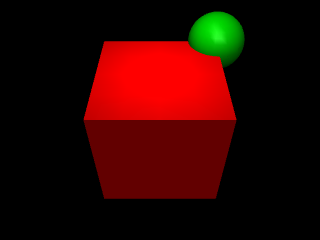

In [9]:

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [10]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render().copy()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)